# MLP Predictor for stock data

## Author: Danilo Filippo Reiszel Pereira
Univesidade Federal do Rio de Janeiro

This notebook contains the creation a Multi-layer Perceptron model to predict D+1 closing prices of PETR4 stocks, using as input 10 delays of its return series and some auxiliary series

In [1]:
from __future__ import print_function
import sys, os
sys.path.append('../../../../src')
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


# Global Params
Setting global params and useful variables, such as directories and image styling

In [2]:
pathPETR4 = '../../../../../data/stocks/PETR4/diario/PETR4.CSV'
pathIBOV = '../../../../../data/indexes/IBOV/diario/IBOV.CSV'
pathUSDBRL = '../../../../../data/forex/USDBRL/diario/USDBRL.CSV'

decomposeModel = 'additive'

saveVarDir = './Variables'
os.makedirs(saveVarDir) if not os.path.exists(saveVarDir) else print('')

saveFigDir = './Figures'
os.makedirs(saveFigDir) if not os.path.exists(saveFigDir) else print('')

saveModelDir = './Models'
os.makedirs(saveModelDir) if not os.path.exists(saveModelDir) else print('')

saveImgFormat = 'png'

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

## Data Acquisition and Preprocessing

Gathers and preprocess data. Data from auxiliary time series (such as IBOV index and USDBRL exchange rate) is also gathered, though tipically less indicators are calculated for this series. Trend Extraction is applied to desired series.

<strong>List of indicators applied to main time series: </strong>
<ul>
    <li>Mean and Standard Deviation, 20 periods</li>
    <li>Returns Calculations:
        <ul>
            <li>Close<sub>d</sub> / Close<sub>d-1</sub></li>
            <li>Close<sub>d</sub> / Open<sub>d</sub></li>
            <li>High<sub>d</sub> / Close<sub>d</sub></li>
            <li>Low<sub>d</sub> / Close<sub>d</sub></li>
        </ul>
    </li>
    <li>EMAs:
        <ul>
            <li>Close, 17 periods</li>
            <li>Close, 72 periods</li>
            <li>Close, 200 periods</li>
            <li>Volume, 21 periods</li>
        </ul>
    </li>
    <li>MACD, fast EMA = 12 periods, slow EMA = 26 periods, signal EMA = 9 periods</li>
    <li>Bollinger Bands, 20 periods</li>
    <li>On-Balance Volume (OBV)</li>
</ul>

In [3]:
init_time = time.time()
PETR4 = acquireData(filePath = pathPETR4,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}, 
                                 {'column': 'Volume', 'lenght': 21}],
                    MACDParams = [{'fast_lenght': 12, 'slow_lenght': 26, 'signal_lenght': 9}],
                    BBParams = [{'lenght': 20}],
                    OBVParams = [{'lenght': None}],
                    colPrefix = 'PETR4',
                    dropNan = True
                   )

IBOV = acquireData(filePath = pathIBOV,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'IBOV',
                    dropNan = True
                  )

USDBRL= acquireData(filePath = pathUSDBRL,
                    replicateForHolidays = True,
                    meanStdLen = 20,
                    returnCalcParams = [['Close'], ['Close', 'Open'], ['High', 'Close' ], ['Low', 'Close']],
                    EMAparams = [{'column': 'Close', 'lenght': 17}, 
                                 {'column': 'Close', 'lenght': 72}, 
                                 {'column': 'Close', 'lenght': 200}],
                    colPrefix = 'USDBRL',
                    dropNan = True
                   )


end_time = time.time()
print('Time to acquire and process data: '+str(end_time-init_time)+' seconds')

Time to acquire and process data: 4.01272010803 seconds


## Dataset concatenation and selection of wich features to feed to the model

In [4]:
df = pd.concat([PETR4, IBOV, USDBRL], axis = 1).dropna()

columnsToUse = [ 
                'PETR4_Close_rollStd20', 
                'PETR4_Close_returns', 'PETR4_Close/Open_returns', 'PETR4_High/Close_returns', 'PETR4_Low/Close_returns', 
                'PETR4_Close_EMA17_logdiff', 'PETR4_Close_EMA72_logdiff', 'PETR4_Close_EMA200_logdiff', 'PETR4_Volume_EMA21_logdiff', 
                'PETR4_MACD_12_26_9', 'PETR4_MACDsignal_12_26_9', 'PETR4_Bollinger%b_20', 'PETR4_OBV', 
                'PETR4_Holiday'
               ]

## Creation of feature matrix and output array, split of data in Train, Validation and Test sets
All data from 2017 is used as Test set, reamining data is split into train and validation according to *validationSplitSize*

In [5]:
xTrain, yTrain, xVal, yVal, xTest, yTest = prepData(df = df, 
                                                    columnsToUse = columnsToUse, 
                                                    columnToPredict = 'PETR4_Close_returns', 
                                                    nDelays = 10, 
                                                    testSetSize = len(df['2017']), 
                                                    validationSplitSize = 0.15)

print('Number of train batches: {}'.format(len(xTrain)))
print('Number of validation batches: {}'.format(len(xVal)))
print('Number of test batches: {}'.format(len(xTest)))
print('Number of inputs per batch: {}'.format(len(xTrain[0])))

Number of train batches: 3557
Number of validation batches: 628
Number of test batches: 175
Number of inputs per batch: 23


## Feature Scalling

In [6]:
xNormScaler = MinMaxScaler(feature_range = (-1,1))
#xScaler = StandardScaler()
xNormScaler.fit(np.append(xTrain, xVal, axis = 0))

yNormScaler = MinMaxScaler(feature_range = (-1,1))
#yScaler = StandardScaler()
yNormScaler.fit(np.append(yTrain, yVal, axis = 0))

xNormTrain = xNormScaler.transform(xTrain)
xNormVal = xNormScaler.transform(xVal)
xNormTest  = xNormScaler.transform(xTest)

yNormTrain = yNormScaler.transform(yTrain)
yNormVal = yNormScaler.transform(yVal)

## Training Parameters

In [7]:
inputDim = xTrain.shape[1]

nFolds = 10 # number of times a topology will be trained
maxNeuronsInHiddenLayer = inputDim # upper limit for number of neurons in hidden layer

# optimizer definition
optimizer = optimizers.SGD(lr=0.003, momentum=0.00, decay=0.0, nesterov=False)

# callbacks definitions
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, mode='auto')

## Finding the best hidden layer

In [8]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto')

bestNormValLoss = np.Inf
bestNormFitHistory = None
bestNormHiddenLayer = 1

init_time = time.time()

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpoint = ModelCheckpoint('./Models/PETR4returns_MLPi23h{}_norm.h5'.format(nNeurons), save_best_only=True)
    for fold in range(nFolds):
        print('training model ({} neurons, fold {})'.format(nNeurons, fold + 1), end='\r')
        model = Sequential([Dense(nNeurons + 1, activation = 'tanh', input_dim = inputDim),
                            Dense(1, activation = 'linear')
                           ])
        model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])

        fitHistory = model.fit(xNormTrain, 
                               yNormTrain, 
                               epochs = 2000,
                               verbose = 0,
                               shuffle = True,
                               validation_data = (xNormVal, yNormVal), 
                               callbacks = [modelCheckpoint,
                                            earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestNormValLoss:
            bestNormValLoss = min(fitHistory.history['val_loss'])
            bestNormFitHistory = fitHistory
            bestNormHiddenLayer = nNeurons

end_time = time.time()

print('Time to fit all models: '+str(end_time-init_time)+' seconds')

bestNormModel = load_model('./Models/PETR4returns_MLPi23h{}_norm.h5'.format(bestNormHiddenLayer))
bestNormModel.summary()

Time to fit all models: 3582.54898381 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 8)                 192       
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 9         
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


## Plot of RMSE per epoch, for Training Set and Validation Set


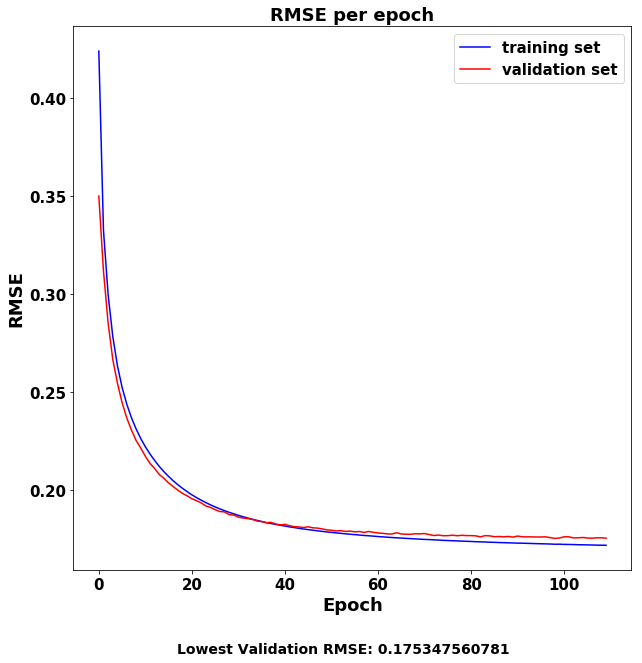

In [9]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestNormFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestNormFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(bestNormFitHistory.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4returns_MLP_norm', 'pdf'), bbox_inches='tight')

## Reconstruction of the time series using predicted values

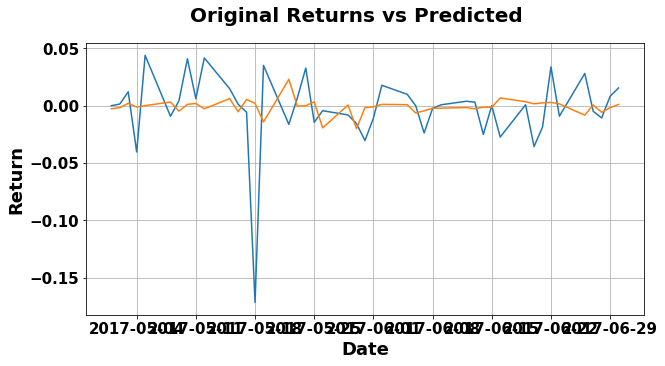

In [32]:
predictions = bestNormModel.predict(xNormTest)
predictions = yNormScaler.inverse_transform(predictions)
predictions_clean = []
for p in predictions:
    predictions_clean.extend(p)
predictionsSeries = pd.Series(predictions_clean, index = df['2017'].index)

fig, ax = plotSeries([df['PETR4_Close_returns'], predictionsSeries],
                     initialPlotDate = '2017-05', finalPlotDate = '2017-06',
                     title = 'Original Returns vs Predicted', ylabel = 'Return')
ax.grid()

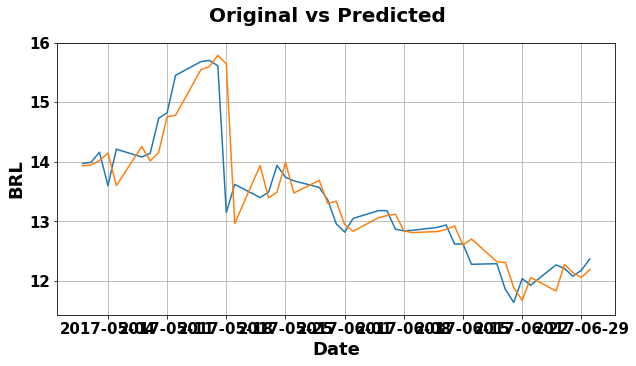

In [33]:
predicted = reconstructReturns(df['PETR4_Close'], predictionsSeries)

fig, ax = plotSeries([df['PETR4_Close'], predicted],
                     initialPlotDate = '2017-05', finalPlotDate = '2017-06',
                     title = 'Original vs Predicted', ylabel = 'BRL')
ax.grid()

## Feature Scalling

In [11]:
#xNormScaler = MinMaxScaler(feature_range = (-1,1))
xStdScaler = StandardScaler()
xStdScaler.fit(np.append(xTrain, xVal, axis = 0))

#yNormScaler = MinMaxScaler(feature_range = (-1,1))
yStdScaler = StandardScaler()
yStdScaler.fit(np.append(yTrain, yVal, axis = 0))

xStdTrain = xStdScaler.transform(xTrain)
xStdVal = xStdScaler.transform(xVal)
xStdTest  = xStdScaler.transform(xTest)

yStdTrain = yStdScaler.transform(yTrain)
yStdVal = yStdScaler.transform(yVal)

## Finding the best hidden layer

In [13]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, mode='auto')

bestStdValLoss = np.Inf
bestStdFitHistory = None
bestStdHiddenLayer = 1

init_time = time.time()

for nNeurons in range(1, maxNeuronsInHiddenLayer + 1):
    modelCheckpoint = ModelCheckpoint('./Models/PETR4returns_MLPi23h{}_std.h5'.format(nNeurons), save_best_only=True)
    for fold in range(nFolds):
        print('training model ({}, {})'.format(nNeurons, fold), end='\r')
        model = Sequential([Dense(nNeurons, activation = 'tanh', input_dim = inputDim),
                            Dense(1, activation = 'linear')
                           ])
        model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])

        fitHistory = model.fit(xStdTrain, 
                               yStdTrain, 
                               epochs = 2000,
                               verbose = 0,
                               shuffle = True,
                               validation_data = (xStdVal, yStdVal), 
                               callbacks = [modelCheckpoint,
                                            earlyStopping])
        
        if min(fitHistory.history['val_loss']) < bestStdValLoss:
            bestStdValLoss = min(fitHistory.history['val_loss'])
            bestStdFitHistory = fitHistory
            bestStdHiddenLayer = nNeurons

end_time = time.time()

print('Time to fit all models: '+str(end_time-init_time)+' seconds')

bestStdModel = load_model('./Models/PETR4returns_MLPi23h{}_std.h5'.format(bestStdHiddenLayer))
bestStdModel.summary()

Time to fit all models: 1643.45802402 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_857 (Dense)            (None, 20)                480       
_________________________________________________________________
dense_858 (Dense)            (None, 1)                 21        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


## Plot of RMSE per epoch, for Training Set and Validation Set


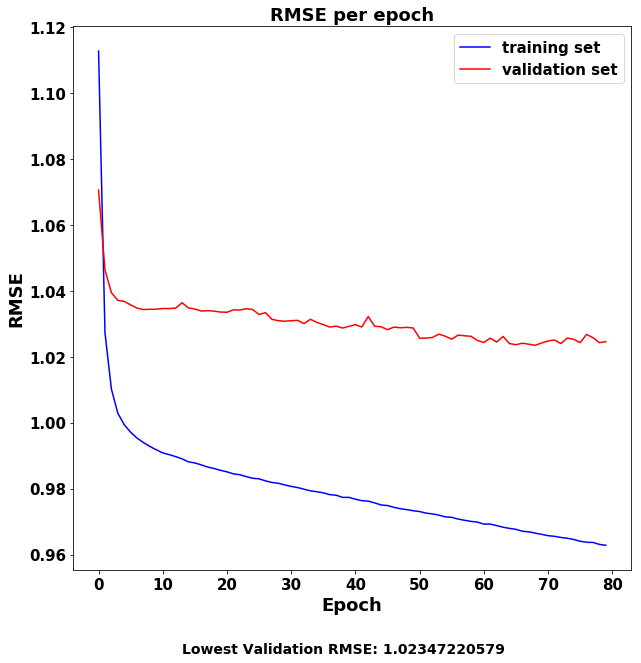

In [14]:
fig, ax = plt.subplots(figsize = (10,10), nrows = 1, ncols = 1)
ax.set_title('RMSE per epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('RMSE')
trainigSet, = ax.plot(np.sqrt(bestStdFitHistory.history['loss']), 'b', label = 'trainig set')
validationSet, = ax.plot(np.sqrt(bestStdFitHistory.history['val_loss']), 'r', label = 'validation set')
plt.legend(handles=[trainigSet, validationSet], labels=['training set', 'validation set'], prop={'size': 15})
plt.figtext(0.5,  0.010, 'Lowest Validation RMSE: {}'.format(np.sqrt(min(bestStdFitHistory.history['val_loss']))), size = 14, horizontalalignment = 'center')
fig.savefig('{}/{}.{}'.format(saveFigDir, 'PETR4returns_MLP_std', 'pdf'), bbox_inches='tight')

## Reconstruction of the time series using predicted values

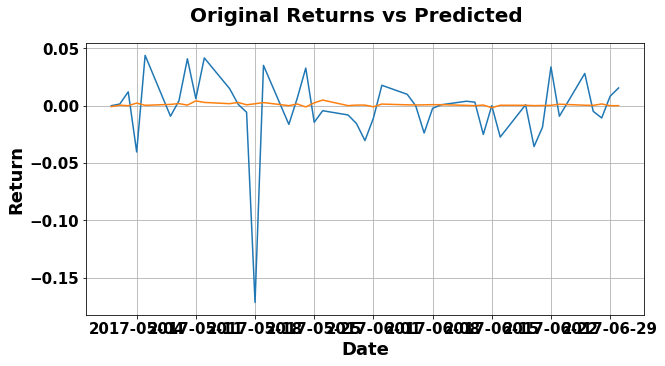

In [34]:
predictions = bestStdModel.predict(xNormTest)
predictions = yStdScaler.inverse_transform(predictions)
predictions_clean = []
for p in predictions:
    predictions_clean.extend(p)
predictionsSeries = pd.Series(predictions_clean, index = df['2017'].index)

fig, ax = plotSeries([df['PETR4_Close_returns'], predictionsSeries],
                     initialPlotDate = '2017-05', finalPlotDate = '2017-06',
                     title = 'Original Returns vs Predicted', ylabel = 'Return')
ax.grid()

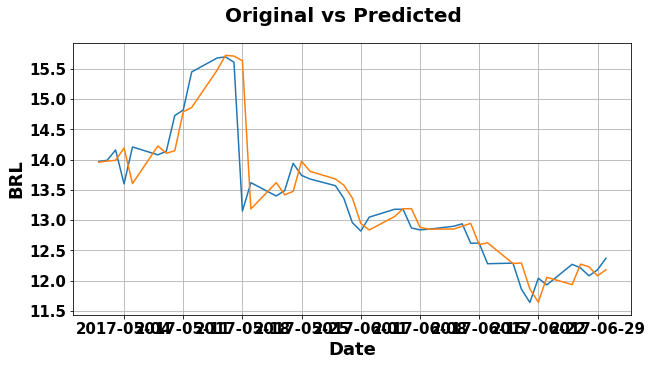

In [35]:
predicted = reconstructReturns(df['PETR4_Close'], predictionsSeries)

fig, ax = plotSeries([df['PETR4_Close'], predicted],
                     initialPlotDate = '2017-05', finalPlotDate = '2017-06',
                     title = 'Original vs Predicted', ylabel = 'BRL')
ax.grid()